In [1]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

In [2]:
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [3]:
import os
import sys

if os.path.abspath('../../..') not in sys.path:
    sys.path.append(os.path.abspath('../../..'))

In [4]:
import json
import re
import logging

from collections import defaultdict

import tqdm

import numpy as np
import pandas as pd

from flashtext import KeywordProcessor

from gensim.parsing.preprocessing import (
    preprocess_string, 
    strip_tags,
    strip_punctuation, 
    strip_multiple_whitespaces, 
    strip_numeric, 
    lower_to_unicode,
    strip_short,
    remove_stopwords,
)
from gensim.corpora.dictionary import Dictionary
from gensim.models import AuthorTopicModel as GensimAuthorTopicModel
from gensim.test.utils import temporary_file
from gensim.models.callbacks import CoherenceMetric, DiffMetric, PerplexityMetric, ConvergenceMetric

from src.dataset import load_tweets, load_availability
from src.config import config

In [5]:
logging.basicConfig(
    format='%(asctime)s:%(levelname)s:%(message)s', 
    level=logging.WARNING,
    handlers=[
        logging.StreamHandler(),
    ]
)

In [6]:
def load_keywords(path=None):
    if path is None:
        path = '../../../data/external/keywords.v3.2.csv'
    df = pd.read_csv(path)
    output = defaultdict(set)
    for row in df.itertuples():
        phrase, topic = row.raw_keyword, row.label
        for token in phrase.split(' '):
            if len(token) > 2:
                output[topic].add(token)
    return {k: list(v) for k, v in output.items()}

keywords = load_keywords()

In [7]:
class Document:
    keyword_processor = None
    url_pattern = re.compile('http[s]?://\S+')
    url_pattern_2 = re.compile('\Bhttp[s]?\S+')
    hashtag_pattern = re.compile('\B\#[a-zA-Z0-9_]+')
    mention_pattern = re.compile('\B\@[a-zA-Z0-9_]+')
    
    def __init__(self, text, author=None):
        self._text = text
        self._author = author
        self._hashtags = Document.hashtag_pattern.findall(self._text)
        self._tokens = preprocess_string(self._text, filters=[
            lower_to_unicode,
            lambda x: Document.url_pattern.sub(' ', x),
            lambda x: Document.hashtag_pattern.sub(' ', x),
            lambda x: Document.mention_pattern.sub(' ', x),
            lambda x: Document.url_pattern_2.sub(' ', x),
            strip_tags,
            strip_punctuation,
            strip_numeric,
            lambda x: x + ' '.join(self._hashtags),
            remove_stopwords,
            strip_short,
            strip_multiple_whitespaces, 
        ])
        if Document.keyword_processor is None:
            Document.keyword_processor = KeywordProcessor()
            Document.keyword_processor.add_keywords_from_dict(keywords)
        self.keywords = Document.keyword_processor.extract_keywords(self._text)
    
    @property
    def text(self):
        return self._text
    
    @property
    def author(self):
        return self._author
    
    @property
    def tokens(self):
        return self._tokens
    
    @property
    def has_keyword(self):
        return len(self.keywords) > 0

In [8]:
def load_documents(path=None):
    if path is None:
        path = '../../../data/interim/models/tweets_intra_subject_analysis.jsonl'
    with open(path, 'r') as fp:
        for line in tqdm.tqdm(fp.readlines(), desc='Loading Documents'):
            record = json.loads(line)
            text = record['tweet']['text']
            author = record['subject_id']
            d = Document(text=text, author=author)
            yield d

results = []
for doc in load_documents():
    if len(doc.tokens) > 5:
        results.append(doc)

Loading Documents: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 820202/820202 [01:23<00:00, 9788.63it/s]


In [9]:
tokenized_docs = []
for i, doc in enumerate(tqdm.tqdm(results, desc='Extracting Tokens')):
    tokenized_docs.append(doc.tokens)

author2doc = defaultdict(list)
for i, doc in enumerate(tqdm.tqdm(results, desc='Extracting Author Docs')):
    author2doc[doc.author].append(i)
author2doc = dict(author2doc)
        
dictionary = Dictionary(tokenized_docs)

corpus = [dictionary.doc2bow(tokenized_doc) for tokenized_doc in tqdm.tqdm(tokenized_docs)]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 602863/602863 [00:07<00:00, 79986.64it/s]


In [10]:
def create_eta(keywords, vocab, num_topics, pseudo_count=1e7, normalize=True):
    # create a (ntopics, nterms) matrix and fill with 1
    eta = np.full(shape=(num_topics, len(vocab)), fill_value=1)
    # for each topic in the seed dict
    topic2id = {topic: i for i, topic in enumerate(keywords)}
    # for each topic in the seed dict
    for topic, tokens in keywords.items(): 
        # for each seed token that is in vocab
        for token in tokens:
            if token in vocab.token2id:
                eta[topic2id[topic], vocab.token2id[token]] = pseudo_count
    if normalize:
        eta = np.divide(eta, eta.sum(axis=0))
    return eta

eta = create_eta(keywords, dictionary, len(keywords) + 1, len(corpus) // 100, normalize=False)

eta.shape

(6, 223073)

In [14]:
try:
    model = GensimAuthorTopicModel.load('../../../data/interim/models/models/v4.pt')
except:
    # Set training parameters.
    kwargs = {
        'passes': 1,
        'iterations': 1,
        'chunksize': 2000,
    }
    with temporary_file('serialized') as s_path:
        model = GensimAuthorTopicModel(
            corpus,
            author2doc=author2doc, 
            chunksize=kwargs.get('chunksize', 1000),
            passes=kwargs.get('passes', 1),
            iterations=kwargs.get('iterations', 1),
            id2word=dictionary, 
            num_topics=eta.shape[0],
            eta=eta,
            serialized=True, 
            serialization_path=s_path,
            eval_every=None,
        )
    model.save('../../../data/interim/models/models/v4.pt')

In [15]:
author_vecs = [model.get_author_topics(author) for author in model.id2author.values()]

In [16]:
# Train the model on the corpus.
for topic_id in range(model.num_topics):
    for term_id, p in model.get_topic_terms(topic_id):
        print('{:>02} {:<30s}{:0.3f}'.format(topic_id, dictionary[term_id], p))

00 oil                           0.013
00 gas                           0.012
00 oxide                         0.012
00 coal                          0.012
00 climate                       0.011
00 emissions                     0.011
00 carbon                        0.011
00 fossil                        0.011
00 pollution                     0.011
00 natural                       0.011
01 wildfire                      0.006
01 heat                          0.006
01 warming                       0.006
01 drought                       0.006
01 average                       0.006
01 ocean                         0.006
01 surface                       0.006
01 wave                          0.006
01 temperature                   0.006
01 sea                           0.006
02 energy                        0.011
02 solar                         0.011
02 wind                          0.011
02 renewable                     0.011
02 carbon                        0.011
02 environmental         

In [17]:
tropic_proba = []

for i in tqdm.tqdm(range(len(results))):
    tropic_proba.append(list(zip(*model.get_new_author_topics(corpus[i:i+1])))[1])
    
tropic_proba = np.array(tropic_proba)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 602863/602863 [01:28<00:00, 6788.28it/s]


In [18]:
np.unique(tropic_proba.argmax(axis=1), return_counts=True)

(array([0, 1, 2, 3, 4, 5]),
 array([   154,    868,     71, 417202, 165983,  18585]))

In [23]:
from sklearn.manifold import TSNE

import seaborn as sns
from src.plotting import bokeh as bhp

sns.set_theme()
bhp.output_notebook()

Loading BokehJS ...

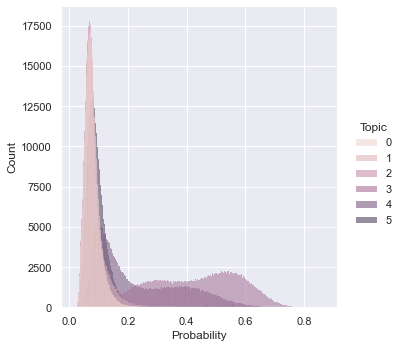

In [21]:
fig_data = [{'Topic': i, 'Probability': p} for i in range(tropic_proba.shape[1]) for p in tropic_proba[:, i]]

fig_df = pd.DataFrame(fig_data)

sns.displot(fig_df, x='Probability', hue='Topic')

In [24]:
%%time
tsne = TSNE(n_components=2, random_state=0)
smallest_author = 0  # Ignore authors with documents less than this.
authors = [model.author2id[a] for a in model.author2id.keys() if len(model.author2doc[a]) >= smallest_author]
_ = tsne.fit_transform(model.state.gamma[authors, :])  # Result stored in tsne.embedding_

x = tsne.embedding_[:, 0]
y = tsne.embedding_[:, 1]
author_names = [model.id2author[a] for a in authors]

# Radius of each point corresponds to the number of documents attributed to that author.
scale = 0.1
author_sizes = [len(model.author2doc[a]) for a in author_names]
radii = [size * scale for size in author_sizes]

source = bhp.ColumnDataSource(
    data=dict(
        x=x,
        y=y,
        author_names=author_names,
        author_sizes=author_sizes,
        radii=radii,
    )
)

# Add author names and sizes to mouse-over info.
hover = bhp.HoverTool(
    tooltips=[
        ("author", "@author_names"),
        ("size", "@author_sizes"),
    ]
)

p = bhp.figure(tools=[hover, 'crosshair,pan,wheel_zoom,box_zoom,reset,save,lasso_select'])
p.scatter('x', 'y', radius='radii', source=source, fill_alpha=0.6, line_color=None)
bhp.show(p)

/Users/yasas/Documents/Projects/climate-matters/evo-lyzer/venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/yasas/Documents/Projects/climate-matters/evo-lyzer/venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


CPU times: user 10.4 s, sys: 593 ms, total: 10.9 s
Wall time: 4.59 s
